Application og Gaussian Process Regression to vertical profiles from scratch!

Ispiration from: https://github.com/peterroelants/peterroelants.github.io/tree/main/notebooks/gaussian_process

# Imports

In [1]:
# imports
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tqdm
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import gruanpy as gp

# Data

In [11]:
# data
path = r'C:\Users\tomma\Documents\SDC\Repos\GRUAN_EDA\gdp\icm16\LIN-RS-01_2_RS41-GDP_001_20170303T120000_1-004-002.nc'
gdp = gp.read(path)
start = gdp.data['time'].values[0]
data=gdp.data[100:400]
time = data['time'].values
seconds = (time - start) / np.timedelta64(1, 's')
seconds = seconds.astype(float)

temp = data['temp'].values
temp_uc = data['temp_uc'].values
temp_variance = (temp_uc / 2)**2   # variance estimate
alt = data['alt'].values
alt_uc = data['alt_uc'].values
alt_variance = (alt_uc / 2)**2
rh = data['rh'].values
rh_uc = data['rh_uc'].values
rh_variance = (rh_uc / 2)**2
press = data['press'].values
press_uc = data['press_uc'].values
press_variance = (press_uc / 2)**2
wspeed = data['wspeed'].values
wspeed_uc = data['wspeed_uc'].values
wspeed_variance = (wspeed_uc / 2)**2
wdir = data['wdir'].values
wdir_uc = data['wdir_uc'].values
wdir_variance = (wdir_uc / 2)**2

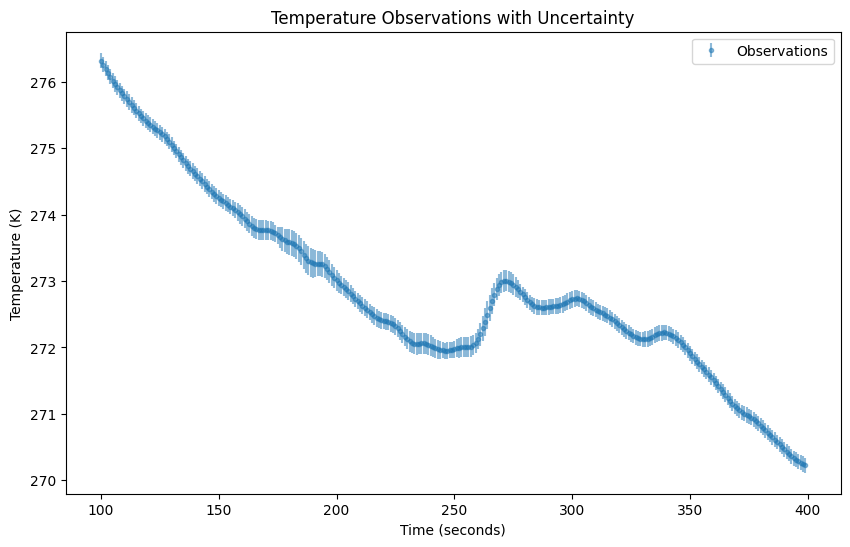

In [19]:
# plot original data with uncertainty
plt.figure(figsize=(10, 6))
plt.errorbar(seconds, temp, yerr=temp_uc, fmt='.', alpha=0.5, label='Observations', color='#1f77b4')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Observations with Uncertainty')
plt.legend()
plt.show()

# GP Regression

In [5]:
# kernel function
def exponential_kernel(x1, x2, length_scale, variance):
    """Exponential kernel function."""
    dists = np.abs(x1[:, None] - x2[None, :])
    return variance * np.exp(-dists / length_scale)

In [6]:
# a priori sampling
length_scale = 50.0  # length scale of the kernel
variance = 1.0       # variance of the kernel
K = exponential_kernel(seconds, seconds, length_scale, variance)
prior = K @ np.random.normal(size=(len(seconds), 3))

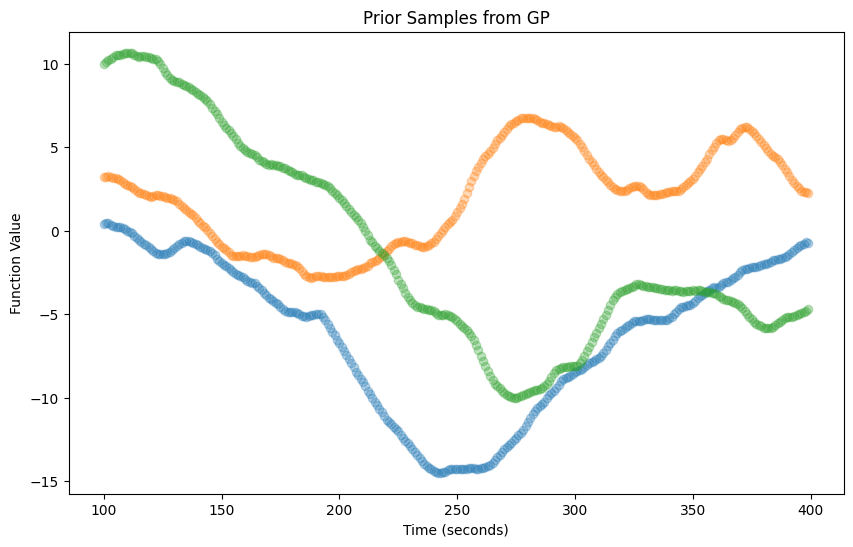

In [7]:
# plot prior samples
plt.figure(figsize=(10, 6))
for i in range(prior.shape[1]):
    plt.scatter(seconds, prior[:, i], alpha=0.3)
plt.title('Prior Samples from GP')
plt.xlabel('Time (seconds)')
plt.ylabel('Function Value')
plt.show()

C:\Users\tomma\AppData\Local\Temp\ipykernel_15236\1518312067.py:39: RuntimeWarning: invalid value encountered in sqrt
  std_post = np.sqrt(np.diag(cov_post))


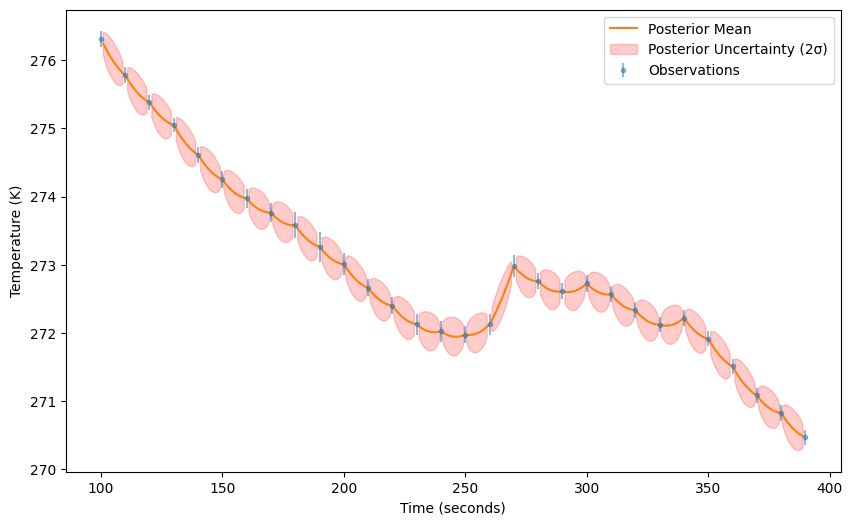

In [8]:
# posterior distribution
train_mask = range(0, len(seconds), 10)
test_mask = range(1, len(seconds)-10, 1)
train_seconds = seconds[train_mask]
train_temp = temp[train_mask]
train_variance = temp_variance[train_mask]
train_temp_uc = temp_uc[train_mask]
test_seconds = seconds[test_mask]
test_temp = temp[test_mask]
test_variance = temp_variance[test_mask]

def posterior_sampling(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

mu_post, cov_post = posterior_sampling(
    train_seconds,
    train_temp,
    test_seconds,
    lambda x1, x2: exponential_kernel(x1, x2, 250, 1.0)
)

# plot mu_post and uncertainty
std_post = np.sqrt(np.diag(cov_post))
plt.figure(figsize=(10, 6))
plt.errorbar(train_seconds, train_temp, yerr=train_temp_uc, fmt='.', alpha=0.5, label='Observations', color='#1f77b4')
plt.plot(test_seconds, mu_post, label='Posterior Mean',  color='#ff7f0e')
plt.fill_between(test_seconds, mu_post - 2*std_post, mu_post + 2*std_post, color='red', alpha=0.2, label='Posterior Uncertainty (2σ)')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

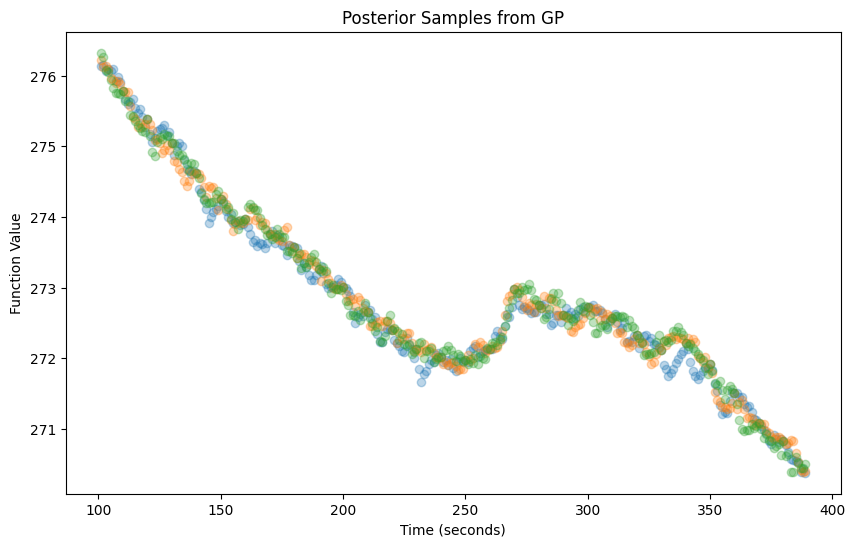

In [9]:
# posterior sampling
# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=mu_post, cov=cov_post, size=3)
# plot posterior samples
plt.figure(figsize=(10, 6))
for i in range(y2.shape[0]):
    plt.scatter(test_seconds, y2[i, :], alpha=0.3)
plt.title('Posterior Samples from GP')
plt.xlabel('Time (seconds)')
plt.ylabel('Function Value')
plt.show()

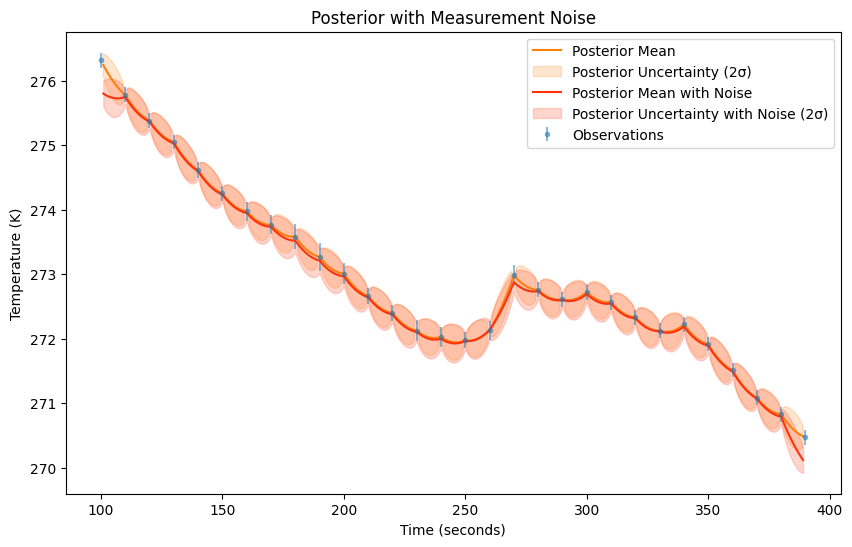

In [10]:
# add measurement error to posterior covariance

def posterior_sampling_with_noise(X1, y1, var1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    observation variances var1, and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1) + np.diag(var1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

mu_post_noise, cov_post_noise = posterior_sampling_with_noise(
    train_seconds,
    train_temp,
    train_variance,
    test_seconds,
    lambda x1, x2: exponential_kernel(x1, x2, 250, 1.0)
)
# plot mu_post and uncertainty with noise
std_post_noise = np.sqrt(np.diag(cov_post_noise))
plt.figure(figsize=(10, 6))
plt.errorbar(train_seconds, train_temp, yerr=train_temp_uc, fmt='.', alpha=0.5, label='Observations', color='#1f77b4')
plt.plot(test_seconds, mu_post, label='Posterior Mean',  color='#ff7f0e')
plt.fill_between(test_seconds, mu_post - 2*std_post, mu_post + 2*std_post, color='#ff7f0e', alpha=0.2, label='Posterior Uncertainty (2σ)')
plt.plot(test_seconds, mu_post_noise, label='Posterior Mean with Noise',  color="#ff320e")
plt.fill_between(test_seconds, mu_post_noise - 2*std_post_noise, mu_post_noise + 2*std_post_noise, color='#ff320e', alpha=0.2, label='Posterior Uncertainty with Noise (2σ)')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.title('Posterior with Measurement Noise')
plt.legend()
plt.show()

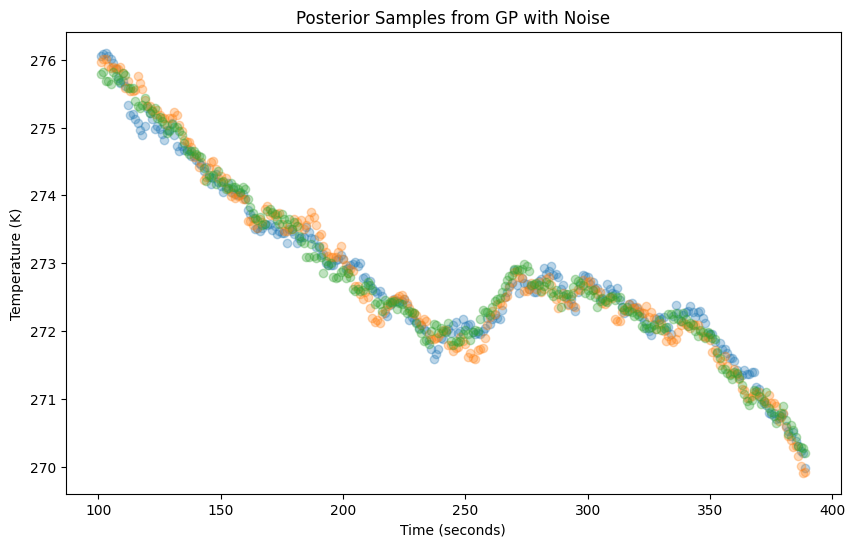

In [11]:
# posterior sampling with noise
y2_noise = np.random.multivariate_normal(mean=mu_post_noise, cov=cov_post_noise, size=3)
# plot posterior samples with noise
plt.figure(figsize=(10, 6))
for i in range(y2_noise.shape[0]):
    plt.scatter(test_seconds, y2_noise[i, :], alpha=0.3)
plt.title('Posterior Samples from GP with Noise')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.show()

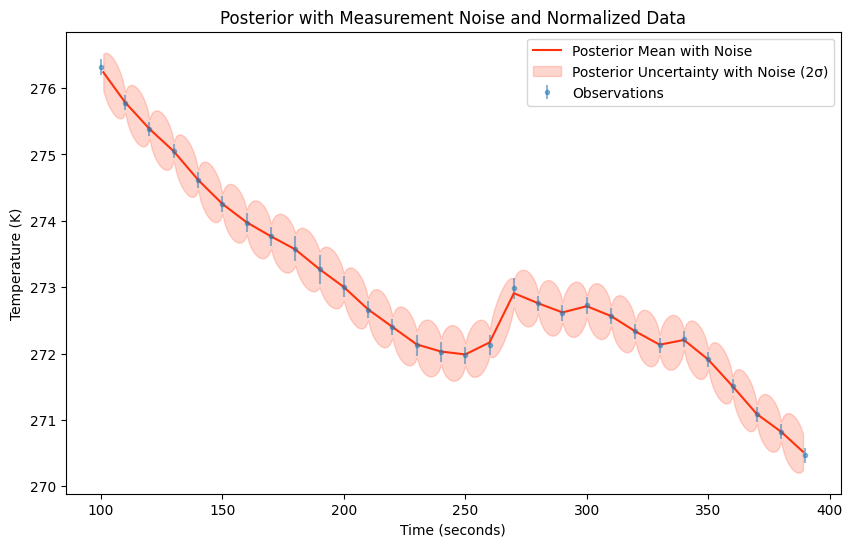

In [12]:
# gp with measurement error and normalized data

avg_temp = np.mean(train_temp)
var_temp = np.var(train_temp)
norm_train_temp = (train_temp - avg_temp) / np.sqrt(var_temp)

mu_post_noise, cov_post_noise = posterior_sampling_with_noise(
    train_seconds,
    norm_train_temp,
    train_variance,
    test_seconds,
    lambda x1, x2: exponential_kernel(x1, x2, 250, 1.0)
)
mu_post_noise = mu_post_noise * np.sqrt(var_temp) + avg_temp
cov_post_noise = cov_post_noise * var_temp
# plot mu_post and uncertainty with noise
std_post_noise = np.sqrt(np.diag(cov_post_noise))
plt.figure(figsize=(10, 6))
plt.errorbar(train_seconds, train_temp, yerr=train_temp_uc, fmt='.', alpha=0.5, label='Observations', color='#1f77b4')
plt.plot(test_seconds, mu_post_noise, label='Posterior Mean with Noise',  color="#ff320e")
plt.fill_between(test_seconds, mu_post_noise - 2*std_post_noise, mu_post_noise + 2*std_post_noise, color='#ff320e', alpha=0.2, label='Posterior Uncertainty with Noise (2σ)')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.title('Posterior with Measurement Noise and Normalized Data')
plt.legend()
plt.show()

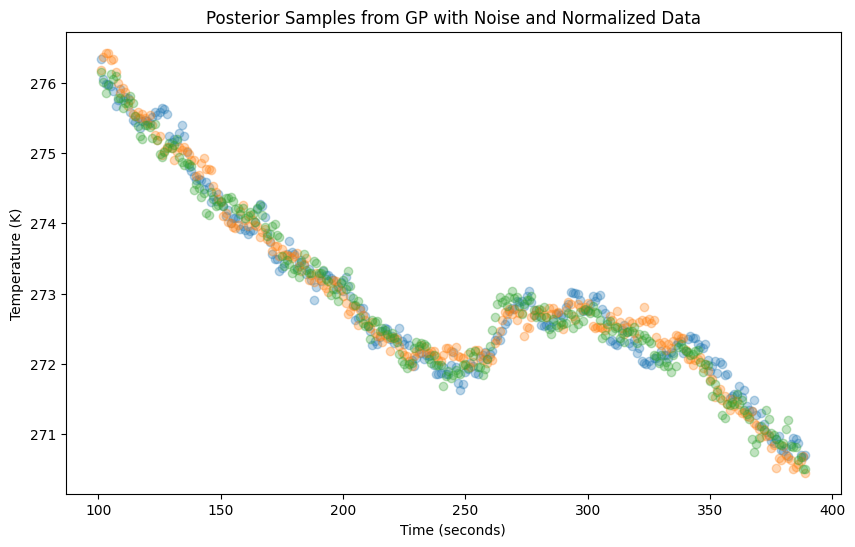

In [13]:
# posterior sampling with noise
y2_noise = np.random.multivariate_normal(mean=mu_post_noise, cov=cov_post_noise, size=3)
# plot posterior samples with noise
plt.figure(figsize=(10, 6))
for i in range(y2_noise.shape[0]):
    plt.scatter(test_seconds, y2_noise[i, :], alpha=0.3)
plt.title('Posterior Samples from GP with Noise and Normalized Data')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.show()

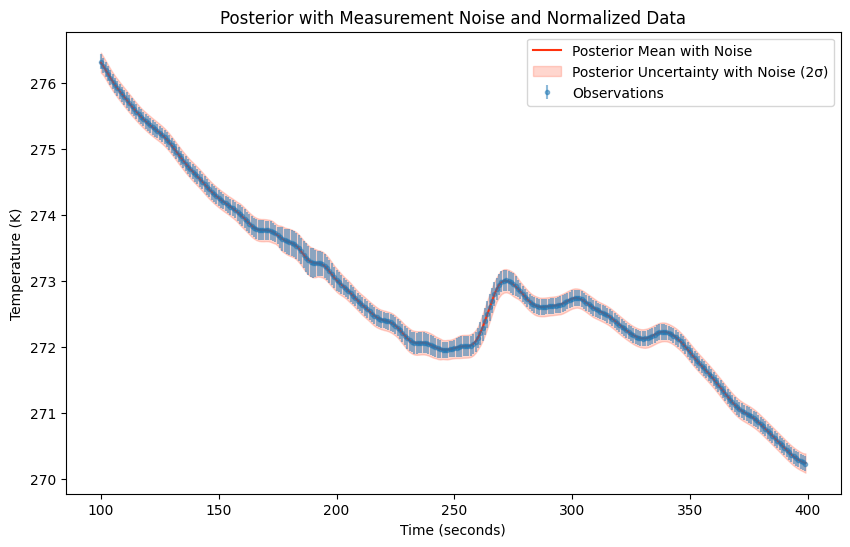

In [14]:
# gp with measurement error and normalized data

avg_temp = np.mean(temp)
var_temp = np.var(temp)
norm_train_temp = (temp - avg_temp) / np.sqrt(var_temp)

mu_post_noise, cov_post_noise = posterior_sampling_with_noise(
    seconds,
    norm_train_temp,
    temp_variance,
    seconds,
    lambda x1, x2: exponential_kernel(x1, x2, 100, 1.0)
)
mu_post_noise = mu_post_noise * np.sqrt(var_temp) + avg_temp
cov_post_noise = cov_post_noise * var_temp
# plot mu_post and uncertainty with noise
std_post_noise = np.sqrt(np.diag(cov_post_noise))
plt.figure(figsize=(10, 6))
plt.errorbar(seconds, temp, yerr=(temp_variance**0.5)*2, fmt='.', alpha=0.5, label='Observations', color='#1f77b4')
plt.plot(seconds, mu_post_noise, label='Posterior Mean with Noise',  color="#ff320e")
plt.fill_between(seconds, mu_post_noise - 2*std_post_noise, mu_post_noise + 2*std_post_noise, color='#ff320e', alpha=0.2, label='Posterior Uncertainty with Noise (2σ)')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.title('Posterior with Measurement Noise and Normalized Data')
plt.legend()
plt.show()

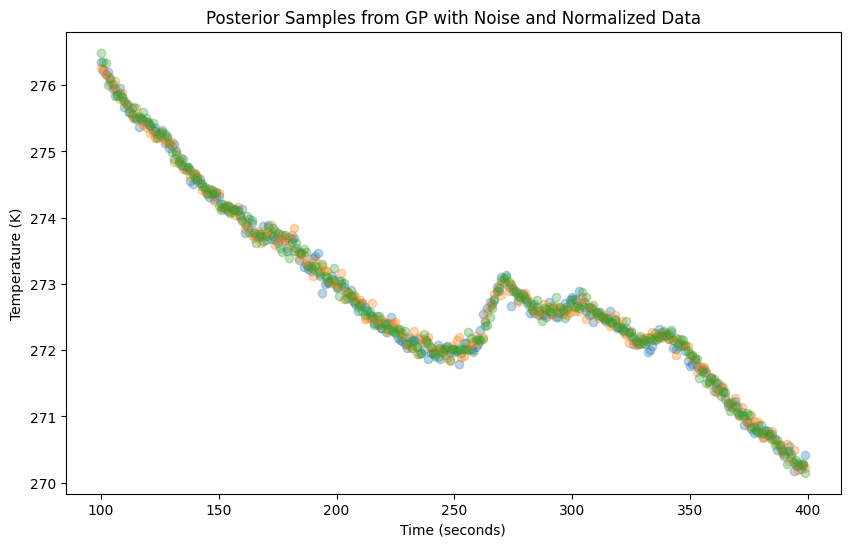

In [15]:
# posterior sampling with noise
y2_noise = np.random.multivariate_normal(mean=mu_post_noise, cov=cov_post_noise, size=3)
# plot posterior samples with noise
plt.figure(figsize=(10, 6))
for i in range(y2_noise.shape[0]):
    plt.scatter(seconds, y2_noise[i, :], alpha=0.3)
plt.title('Posterior Samples from GP with Noise and Normalized Data')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.show()

# Hyperparameter tuning

In [3]:
# more imports
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


Gaussian process regression (GPR)

**kernel:**

The kernel specifying the covariance function of the GP.

**alpha:**

Value added to the diagonal of the kernel matrix during fitting.
This can prevent a potential numerical issue during fitting, by
ensuring that the calculated values form a positive definite matrix.
It can also be interpreted as the variance of additional Gaussian
measurement noise on the training observations. Note that this is
different from using a `WhiteKernel`. If an array is passed, it must have the same number of entries as the data used for fitting and is used as datapoint-dependent noise level.

**optimizer:**

Can either be one of the internally supported optimizers for optimizing the kernel's parameters, specified by a string, or an externally defined optimizer passed as a callable. 
If None is passed, the kernel's parameters are kept fixed. Per default, the L-BFGS-B algorithm.

**n_restarts_optimizer:**

The number of restarts of the optimizer for finding the kernel's
parameters which maximize the **log-marginal likelihood**. The first run of the optimizer is performed from the kernel's initial parameters, the remaining ones (if any) from thetas sampled log-uniform randomly from the space of allowed theta-values. Note that `n_restarts_optimizer == 0` implies that one run is performed.

**normalize_y:**

Whether or not to normalize the target values `y` by removing the mean and scaling to unit-variance. This is recommended for cases where zero-mean, unit-variance priors are used. Note that, in this implementation, the normalisation is reversed before the GP predictions are reported.

**copy_X_train:**

If True, a persistent copy of the training data is stored in the
object. Otherwise, just a reference to the training data is stored,
which might cause predictions to change if the data is modified
externally.

**random_state:**

Determines random number generation used to initialize the centers.
Pass an int for reproducible results across multiple function calls.


In [50]:
def fit_and_plot_gp(model, X, y, y_uc, plot_interpolation=True, ylabel='Temperature (K)'):
    seconds = X.ravel()
    # Fit to data
    model.fit(X, y)
    # Predict
    X_pred = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
    y_pred, y_std = model.predict(X_pred, return_std=True)
    if plot_interpolation:
        # Plot results
        plt.figure(figsize=(12, 8))
        plt.plot(seconds, y, label='Data', alpha=0.5)
        plt.fill_between(seconds, y - y_uc, y + y_uc, alpha=0.5, label='Uncertainty')

        # Plot prediction
        plt.plot(X_pred, y_pred, label='Prediction', color='red')
        plt.fill_between(X_pred.ravel(), y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='red', label='±2σ')

        # Sample 3 simulations from the GP
        y_samples = model.sample_y(X_pred, n_samples=3, random_state=42)

        # Plot simulations
        for i in range(3):
            plt.plot(X_pred, y_samples[:, i], alpha=0.7, label=f'Simulation {i+1}')

        plt.xlabel('Time (seconds)')
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()
    else:
        # Plot results
        plt.figure(figsize=(12, 8))
        plt.scatter(seconds, y, label='Data', alpha=0.5)
        plt.errorbar(seconds, y, yerr=y_uc, fmt='.', alpha=0.5, label='Uncertainty')

        # Plot prediction
        plt.scatter(X_pred, y_pred, label='Prediction', color='red')
        plt.errorbar(X_pred.ravel(), y_pred, yerr=2*y_std, fmt='.', alpha=0.5, color='red', label='±2σ')

        # Sample 3 simulations from the GP
        y_samples = model.sample_y(X_pred, n_samples=3, random_state=42)

        # Plot simulations
        #for i in range(3):
        #    plt.scatter(X_pred, y_samples[:, i], alpha=0.7, label=f'Simulation {i+1}')

        plt.xlabel('Time (seconds)')
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()

    return model

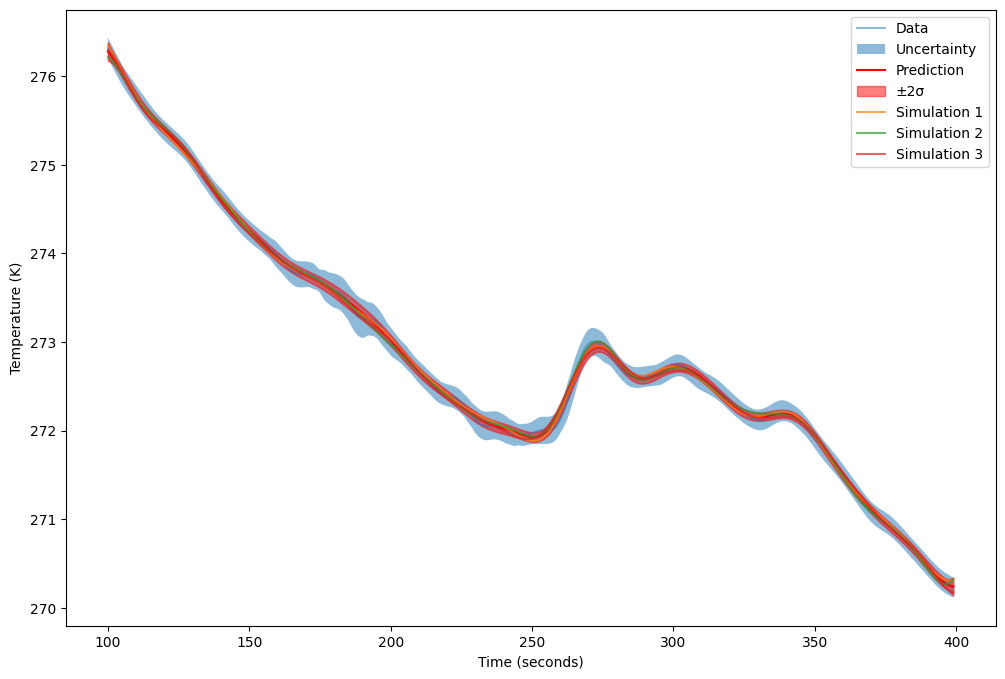

   length_scale length_scale_bounds
0      16.05544   (1e-05, 100000.0)
Log-Marginal-Likelihood: 441.32120133868017


In [51]:
# - Squared Exponential (RBF) kernel
# - optimization of hyperparameters
# - varying noise level according to temp variance
# - normalize_y=True

X = seconds.reshape(-1, 1)
# Define kernel and GP model
kernel = RBF()#length_scale=10.0)
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=temp_variance,
    normalize_y=True)
# Fit and plot
gp_model=fit_and_plot_gp(gp_model, X, temp, temp_uc)
print(pd.DataFrame([gp_model.kernel_.get_params()]))
print(f"Log-Marginal-Likelihood: {gp_model.log_marginal_likelihood(gp_model.kernel_.theta)}")

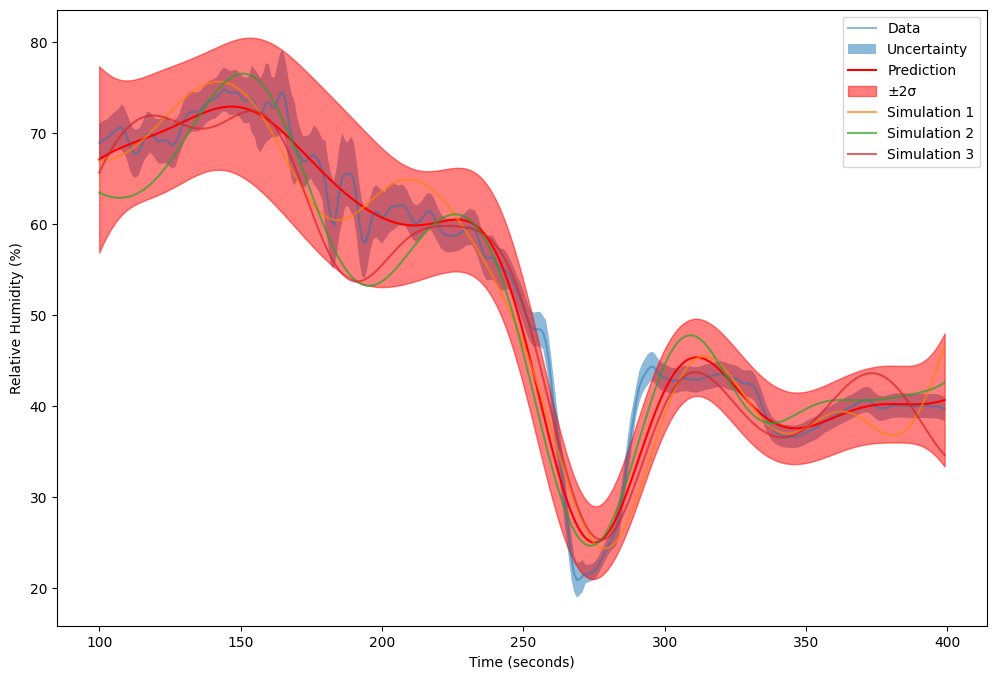

   length_scale length_scale_bounds
0     24.489941   (1e-05, 100000.0)
Log-Marginal-Likelihood: -296.874320524112


In [52]:
# - Squared Exponential (RBF) kernel
# - optimization of hyperparameters
# - varying noise level according to temp variance
# - normalize_y=True

X = seconds.reshape(-1, 1)
# Define kernel and GP model
kernel = RBF()#length_scale=10.0)
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=rh_variance,
    normalize_y=True)
# Fit and plot
gp_model=fit_and_plot_gp(gp_model, X, rh, rh_uc, ylabel='Relative Humidity (%)')
print(pd.DataFrame([gp_model.kernel_.get_params()]))
print(f"Log-Marginal-Likelihood: {gp_model.log_marginal_likelihood(gp_model.kernel_.theta)}")

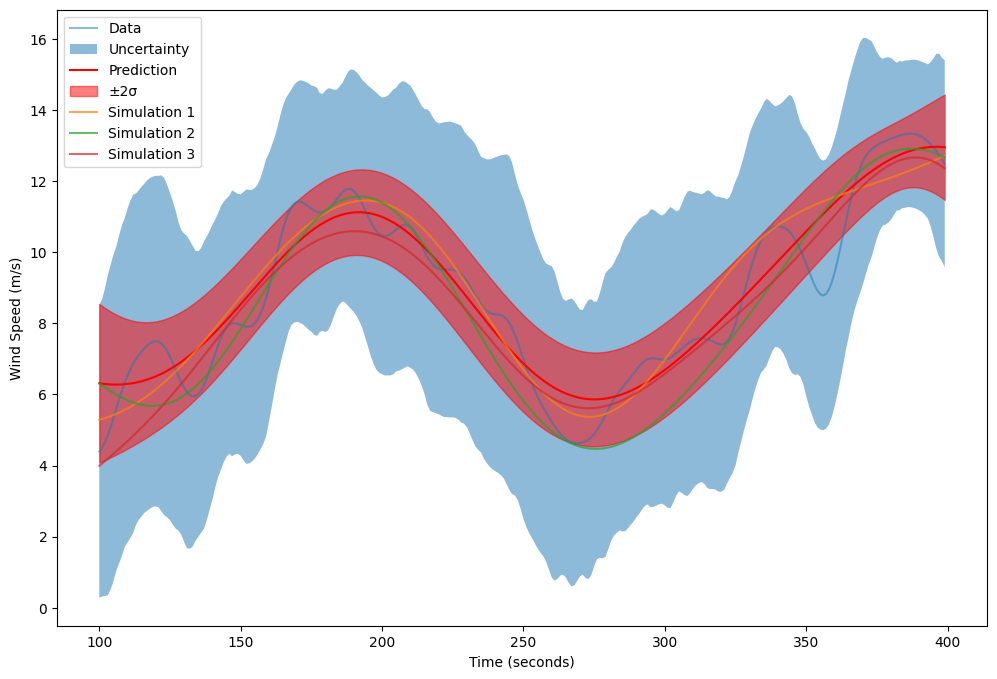

   length_scale length_scale_bounds
0     42.923644   (1e-05, 100000.0)
Log-Marginal-Likelihood: -482.0236094694692


In [53]:
# - Squared Exponential (RBF) kernel
# - optimization of hyperparameters
# - varying noise level according to temp variance
# - normalize_y=True

X = seconds.reshape(-1, 1)
# Define kernel and GP model
kernel = RBF()#length_scale=10.0)
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=wspeed_variance,
    normalize_y=True)
# Fit and plot
gp_model=fit_and_plot_gp(gp_model, X, wspeed, wspeed_uc, ylabel='Wind Speed (m/s)')
print(pd.DataFrame([gp_model.kernel_.get_params()]))
print(f"Log-Marginal-Likelihood: {gp_model.log_marginal_likelihood(gp_model.kernel_.theta)}")

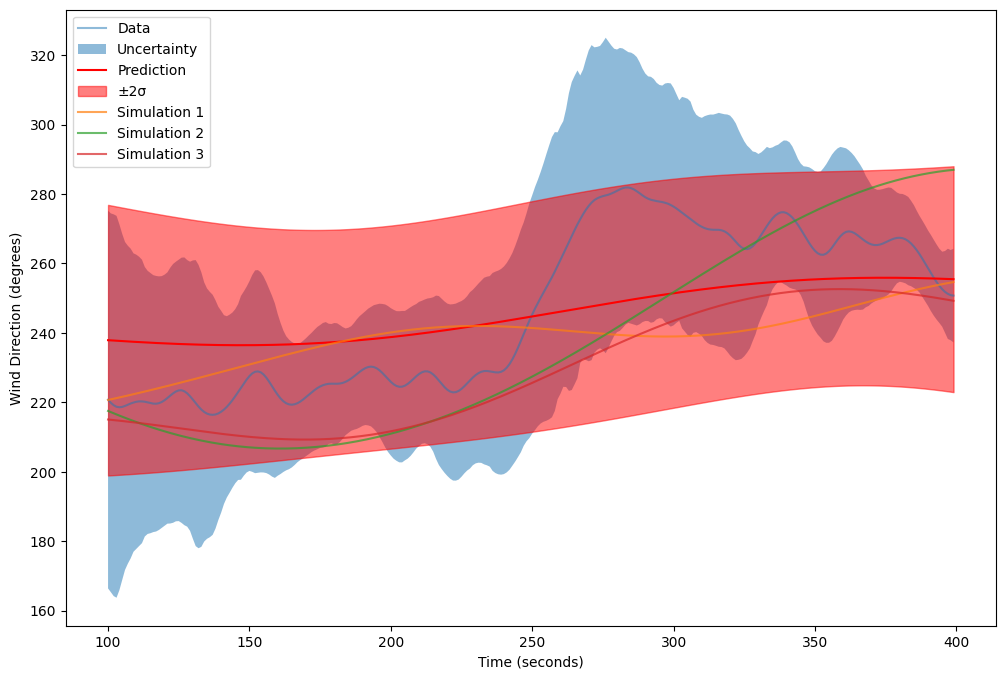

   length_scale length_scale_bounds
0     95.900903   (1e-05, 100000.0)
Log-Marginal-Likelihood: -1047.6589125348714


In [54]:
# - Squared Exponential (RBF) kernel
# - optimization of hyperparameters
# - varying noise level according to temp variance
# - normalize_y=True

X = seconds.reshape(-1, 1)
# Define kernel and GP model
kernel = RBF()#length_scale=10.0)
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=wdir_variance,
    normalize_y=True)
# Fit and plot
gp_model=fit_and_plot_gp(gp_model, X, wdir, wdir_uc, ylabel='Wind Direction (degrees)')
print(pd.DataFrame([gp_model.kernel_.get_params()]))
print(f"Log-Marginal-Likelihood: {gp_model.log_marginal_likelihood(gp_model.kernel_.theta)}")

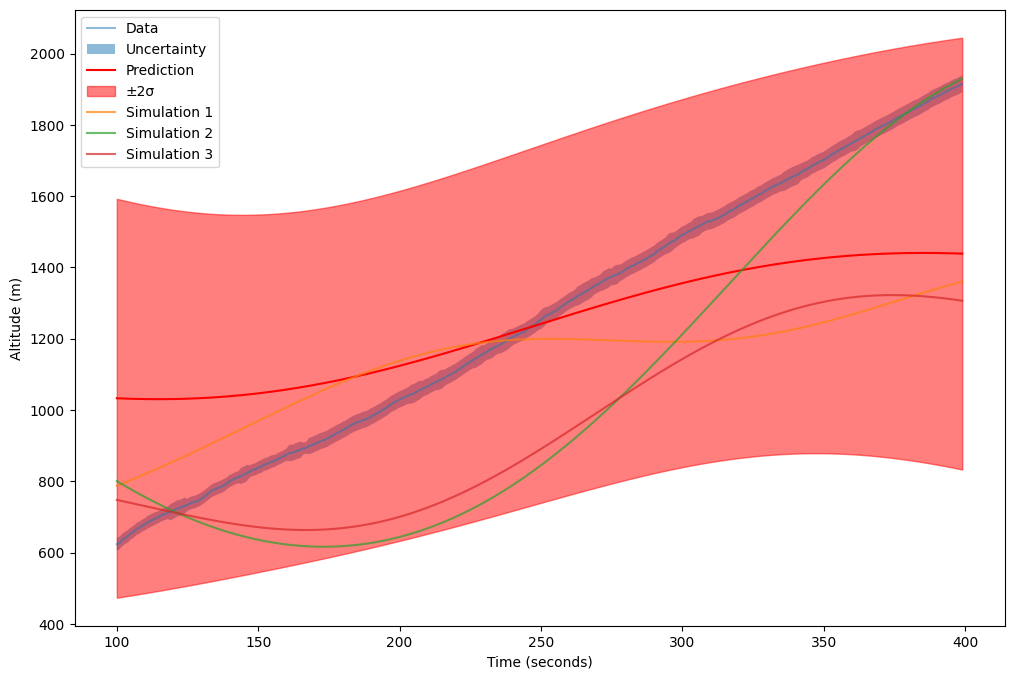

   length_scale length_scale_bounds
0    110.497642   (1e-05, 100000.0)
Log-Marginal-Likelihood: -1003.5706171238103


In [55]:
# - Squared Exponential (RBF) kernel
# - optimization of hyperparameters
# - varying noise level according to temp variance
# - normalize_y=True

X = seconds.reshape(-1, 1)
# Define kernel and GP model
kernel = RBF()#length_scale=10.0)
alt_gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=alt_variance,
    normalize_y=True)
# Fit and plot
alt_gp_model=fit_and_plot_gp(alt_gp_model, X, alt, alt_uc, ylabel='Altitude (m)')
print(pd.DataFrame([alt_gp_model.kernel_.get_params()]))
print(f"Log-Marginal-Likelihood: {alt_gp_model.log_marginal_likelihood(alt_gp_model.kernel_.theta)}")

c:\Users\tomma\Documents\SDC\Repos\GRUAN_EDA\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


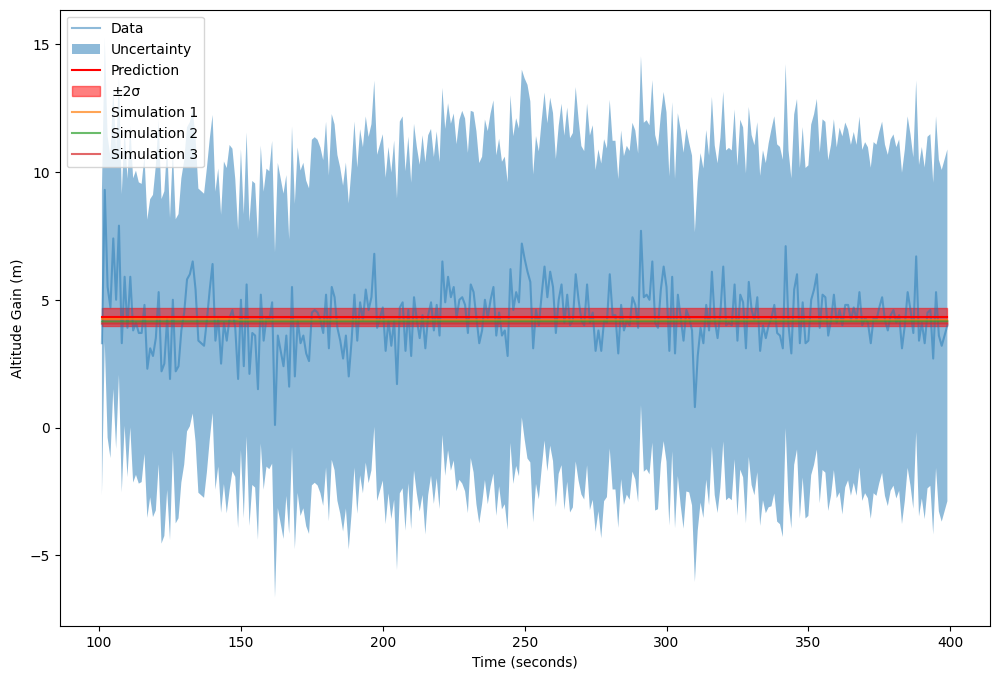

   length_scale length_scale_bounds
0      100000.0   (1e-05, 100000.0)
Log-Marginal-Likelihood: -584.2113078269555


In [59]:
# - Squared Exponential (RBF) kernel
# - optimization of hyperparameters
# - varying noise level according to temp variance
# - normalize_y=True

X = seconds[1:].reshape(-1, 1)
# Define kernel and GP model
kernel = RBF()

alt_gain = np.array([alt[i] - alt[i-1] for i in range(1, len(alt))])
alt_gain_uc = np.array([np.sqrt(alt_uc[i]*0.5**2 + alt_uc[i-1]*0.5**2)*2 for i in range(1, len(alt_uc))])
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=alt_gain_uc,
    normalize_y=True)
# Fit and plot
gp_model=fit_and_plot_gp(gp_model, X, alt_gain, alt_gain_uc, ylabel='Altitude Gain (m)')
print(pd.DataFrame([gp_model.kernel_.get_params()]))
print(f"Log-Marginal-Likelihood: {gp_model.log_marginal_likelihood(gp_model.kernel_.theta)}")